<a href="https://colab.research.google.com/github/beekal/MachieneLearningProjects/blob/master/2.%20Deep%20Learning/5.%20ULMFit/Fine_Tuning_ULMFit_For_Multi_class_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Why ULMFit ?** :
Unlike in Image Domain, where transfer learning is used extensively (where lower layers of the ImageNet capture lower level image features that can be transferred easily to  other domain task), transfer learning for NLP has been limited/ lacking, except for the transfer learning of word vectors. 

ULMFit provides a level up  to NLP in that it allows the transfer learning of the whole network architecture, that can be fine tuned to the required tasks.

----------------------
**Question** : What is the data used ?

**Answer** : ULMFit is trained on about 30,000  wikipedia articles containing 100 million words.

----------------------

**Question** : So how does it handle the word vector representation ?

**Answer** : Well, the word unlike in Word vectors where they are externally represented and can be used, the word vectors for about 100 million words are implictly maintained in the architecture using the Language Model (Language model predicts the next word given a word).

----------------------

**Question** : So what happens if there is a word not present in the 100 million word vocabulary used during pre-training ?

**Answer** : Well, those words would  not be properly represented. Such cases would need to be addressed by fine-tuning the Language model. By providing the words to the Language model during the language model training, any OOV words would  can be added.

----------------------


**Question** : Is it the state of art Language Model ?

**Answer** : It was the state of art on 2018. However things haved moved a long way in the last two years. Today, Bert which has been trained on much more larger Dataset, is much more deeper (12-24 layers deep) with attention mechanism(allowing parallelisation for  speed and can handle longer text sequence ) is the state of art on all major NLU tasks.

----------------------


**Question** : So Why are we fine-tuning to a old Model ?

**Answer** : Well, this is just a practice session, to try it out.

----------------------

**Question**:  Ok, let's get into Practise ?
Ok, Let's Start

In [1]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
     |████████████████████████████████| 704.8MB 27kB/s 


In [2]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [3]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

In [109]:
df = pd.DataFrame({'label':dataset.target, 'text':dataset.data})
df_lm = df

In [110]:
df['label'].value_counts()

10    600
15    599
8     598
9     597
11    595
13    594
7     594
14    593
5     593
12    591
2     591
3     590
6     585
1     584
4     578
17    564
16    546
0     480
18    465
19    377
Name: label, dtype: int64

In [111]:
# df = df[df['label'].isin([1,10])]
df = df.reset_index(drop = True)

In [112]:
df['label'].value_counts()

10    600
15    599
8     598
9     597
11    595
13    594
7     594
14    593
5     593
12    591
2     591
3     590
6     585
1     584
4     578
17    564
16    546
0     480
18    465
19    377
Name: label, dtype: int64

In [113]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.4, random_state = 12)


In [114]:
df_trn.shape, df_val.shape


((6788, 2), (4526, 2))

In [115]:
# Language model data
# Data used to train the language model. For e.g  Determine which word comes next given a word.
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
# Data used to train classification model
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [116]:
data_clas.show_batch()

text,target
xxbos xxmaj due to the resolution and size it is in 14 parts . \n \n xxmaj this is a uuencoded bitmap . xxup xxunk 256 colors . \n xxmaj the picture is a xxunk xxunk on a desert with blue sky background . \n xxmaj the size is just right for centered wallpaper on a 1024x768 display \n because it leaves a border at the,2
"xxbos xxrep 10 - cut here xxrep 10 - part 03 / 03 \n xxup xxunk a \ - \ ( $ xxup xxunk xxup xxunk < # xxup xxunk ( \n xxup xxunk u ) xxup xxunk / xxup xxunk < xxup xxunk # xxup xxunk xxup ad . "" / , ( , xxup v1 # & w ; \n xxup xxunk xxup xxunk :",2
"xxbos xxmaj try the firearms archive . xxmaj larry xxmaj cipriani 's instructions follow . xxmaj by \n the way , thanks for the archive xxmaj larry .. \n \n xxmaj this year is the 103rd congress directory . \n \n xxrep 28 - \n xxmaj from \n watson!yktnews.watson.ibm.com!newsgate.watson.ibm.com!news.ans.net!howland.r \n reston.ans.net!bogus.sura.net!darwin.sura.net!dtix.dt.navy.mil!mimsy!cbvox1 . \n .att.com!lvc xxmaj thu xxmaj apr 8 xxunk 1993 \n",16
"xxbos \n xxrep 12 - xxmaj part 3 of 14 xxrep 12 - \n xxup xxunk xxwrep 2 xxup 3dy . 2 # xxup ij : xxup fij : f \n xxup xxunk # xxup xxunk - xxup xxunk # xxup xxunk - xxup sv # xxup hz \n xxup mrg / xxup xxunk # xxup xxunk , xxup xxunk < w - s < w",2
"xxbos xxmaj archive - name : net - privacy / part2 \n xxmaj last - modified : 1993 / 3 / 3 \n xxmaj version : 2.1 \n \n \n xxup identity , xxup privacy , and xxup anonymity on the xxup internet \n xxrep 48 = \n \n ( c ) 1993 xxup l. xxmaj detweiler . xxmaj not for commercial use except by",11


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 1.45E-02
Suggested Learning Rate is   0.03981071705534969


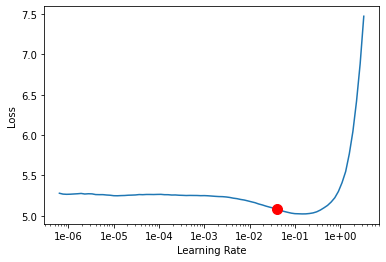

In [117]:
# data_lm = language model, AWD_LSTM =model architecture, drop_mult = dropout
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
# Runs for few epochs and  calculatees minimum gradient
learn.lr_find()

# Find optimal learning rate for our model by plotting it.
# Choose learning rate order of magnitude below which loss diverge i.e 1e-3
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr
print('Suggested Learning Rate is  ', min_grad_lr)

In [118]:
learn.fit_one_cycle(5, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.353243,4.223244,0.269213,01:24
1,4.325517,4.314600,0.264283,01:24
2,4.110059,4.173910,0.277729,01:24
3,3.669077,4.005179,0.293378,01:24
4,3.285319,3.971804,0.298395,01:24


In [95]:
# Run for many epochs with all layers unfrozen.
# IMP: Do not run for training with all layers unfrozen for a lot of epochs, or else you will start unlearning things learned from pre-training
learn.unfreeze()
learn.fit_one_cycle(cyc_len=5, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.454832,5.129586,0.256264,00:51
1,4.351589,5.080005,0.262474,00:51
2,4.002023,5.060701,0.266659,00:51
3,3.694354,5.128103,0.266100,00:51
4,3.430765,5.162028,0.264280,00:51


In [119]:
# We only achieved the accuracy of 29 %. 
# We should not be alramed because this is the accuracy of the language model at predicting thenext word given a word. 
# Let;s try the Language model with  some examples
learn.predict("How do", n_words=10)

'How do you write out the X11R5 ? \n \n  Given'

In [120]:
# let's save the language model
learn.save_encoder('ft_enc')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 2.09E-02
Suggested learning rate for text classification is  0.019054607179632484


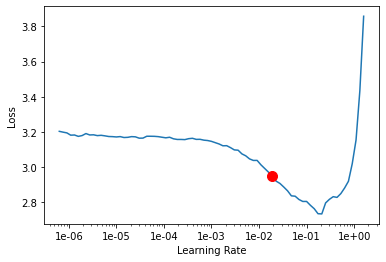

In [121]:
# Now let's train the text classifier using the language model
learn = text_classifier_learner(data_clas,AWD_LSTM,  drop_mult=0.5)
learn.load_encoder('ft_enc')
learn.freeze()

# Let's find optimum learning rate for  text classifier in the same way we did for language model
learn.lr_find()
learn.recorder.plot(suggestion=True)
suggested_grad_lr_text_classif = learn.recorder.min_grad_lr
print('Suggested learning rate for text classification is ', suggested_grad_lr_text_classif)

In [122]:
learn_bkup = learn

In [123]:
## GRadually unfreeze the layers while running one epoch each time as suggested by the ULMFIt paper
# Helps get better accuracy than  if aggressively train all layer at once
learn.fit_one_cycle(5, suggested_grad_lr_text_classif)

epoch,train_loss,valid_loss,accuracy,time
0,1.820949,1.759317,0.461555,01:06
1,1.796001,1.478060,0.530932,01:10
2,1.789140,1.431422,0.565842,01:08
3,1.617412,1.350771,0.591251,01:08
4,1.353348,1.355551,0.591030,01:08


In [124]:
#  Fit more if the drop is still continuing at reasonable pace
learn.fit_one_cycle(1, suggested_grad_lr_text_classif)

epoch,train_loss,valid_loss,accuracy,time
0,1.514434,1.395604,0.574901,01:01


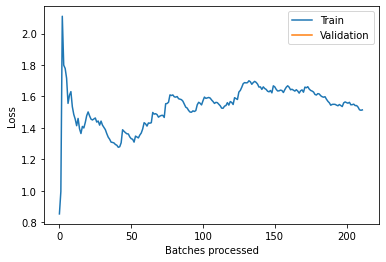

In [125]:
learn.recorder.plot_losses()

In [126]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3,2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.526809,1.331426,0.599426,01:10


In [128]:
# Started diverging. Lets lower the learning rate 
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3, 2e-3), moms=(0.8,0.7) )

epoch,train_loss,valid_loss,accuracy,time
0,1.252088,1.097499,0.660627,01:33


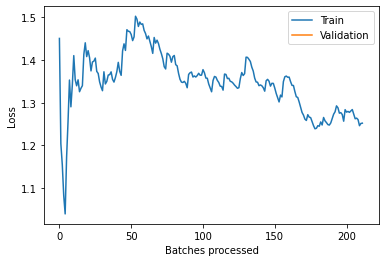

In [129]:
learn.recorder.plot_losses()

In [130]:
# Now lets unfreeze all and train at lower learning rate because we are converging now and we  dont want to forget what ULMFit has learned during pre-training
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-3/100,2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.036561,1.061600,0.666593,01:47
1,0.901413,1.037271,0.680292,01:41
2,0.869986,1.022139,0.688246,01:40
3,0.819948,1.012812,0.688688,01:43


In [132]:
# Now lets unfreeze all and train at lower learning rate because we are converging now and we  dont want to forget what ULMFit has learned during pre-training
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-3/10,2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.700389,1.037219,0.681838,01:40
1,0.848766,1.077277,0.687804,01:34
2,0.543029,0.993783,0.698409,01:49
3,0.417168,0.984744,0.704375,01:48


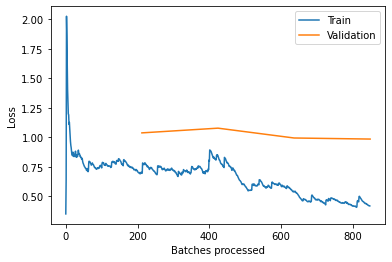

In [133]:
learn.recorder.plot_losses()

In [134]:
# Now we have the model with 80% accuracy let's see the predictions on our validation data

# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
row_0,,,,,,,,,,,,,,,,,,,,
0,112,1,1,0,0,1,1,5,3,2,1,4,0,3,6,13,3,7,9,32
1,1,153,20,15,12,26,5,2,2,5,0,7,7,4,9,4,2,1,1,3
2,1,19,156,23,9,11,4,1,0,0,1,4,3,1,2,0,1,0,0,0
3,1,9,26,136,18,2,9,2,0,0,0,1,19,0,2,0,0,0,0,0
4,0,4,7,17,160,1,5,3,1,1,0,3,8,0,0,0,1,0,0,0
5,0,15,9,4,3,188,0,0,1,0,0,2,1,0,1,1,0,1,0,0
6,0,4,3,8,5,1,173,7,8,1,0,3,10,1,0,0,4,0,1,0
7,4,3,1,3,5,1,9,160,16,3,7,2,12,3,4,2,4,1,5,1
8,6,0,1,1,0,1,2,15,177,2,0,0,4,3,3,0,2,3,5,0


The result is ok. However it can be further played around and tuned. However we will stop here for now having completed the goal of demoing sucessful fine-tuning of ULMFit for multi-class classification.


In [135]:

## Now let's predict
## Expected 16 
learn.predict("News related to war and guns")

(Category tensor(16),
 tensor(16),
 tensor([9.1623e-04, 3.6651e-04, 9.2387e-06, 1.4390e-04, 6.9658e-04, 1.9121e-05,
         4.4772e-03, 7.1259e-05, 1.4992e-04, 5.8432e-05, 3.9062e-06, 3.4167e-01,
         3.7738e-04, 1.6297e-04, 3.1764e-05, 1.5466e-05, 5.6633e-01, 7.4197e-02,
         8.7535e-03, 1.5530e-03]))

## REF: 

https://arxiv.org/abs/1801.06146

https://www.analyticsvidhya.com/blog/2018/11/tutorial-text-classification-ulmfit-fastai-library/

https://towardsdatascience.com/transfer-learning-in-nlp-for-tweet-stance-classification-8ab014da8dde

https://medium.com/technonerds/using-fastais-ulmfit-to-make-a-state-of-the-art-multi-label-text-classifier-bf54e2943e83